286720/274707 [===============================] - 0s 1us/step


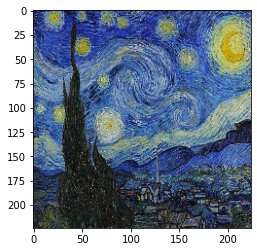

In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

style_path = tf.keras.utils.get_file('style2.jpg', 'https://mblogthumb-phinf.pstatic.net/MjAyMDA0MThfMjAz/MDAxNTg3MTgwNjUyMjQy.eg-2jPP6tP08h4hdoqVT2H3vJKl4PGuLQp7_1zARoOUg.Qx1Vo75Sw2MU4E3QTRwxqmmef_c7eEZq8y95sEgaK3Ug.JPEG.ipssinhada2/SE-82cb2733-f3bf-4ad7-8ee5-3867275c6f8d.jpg?type=w800')

style_image = plt.imread(style_path)
style_image = cv2.resize(style_image, dsize=(224, 224))
style_image = style_image / 255.0
plt.imshow(style_image)

tf.Tensor([0.56022    0.4691434  0.02020967], shape=(3,), dtype=float32)


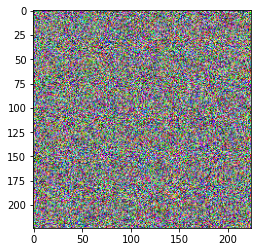

In [17]:
target_image = tf.random.uniform(style_image.shape)
print(target_image[0,0,:])
plt.imshow(target_image)

In [18]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

vgg = VGG19(include_top=False, weights='imagenet')

for layer in vgg.layers:
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [19]:
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

vgg.trainable = False
outputs = [vgg.get_layer(name).output for name in style_layers]
model = tf.keras.Model([vgg.input], outputs)

(1, 224, 224, 64)


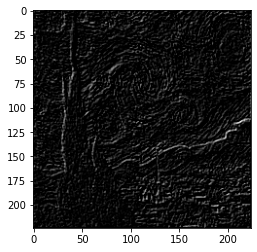

In [20]:
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

style_image = plt.imread(style_path)
style_image = cv2.resize(style_image, dsize=(224, 224))
style_image = style_image / 255.0

style_batch = style_image.astype('float32')
style_batch = tf.expand_dims(style_batch, axis=0)
style_output = model(preprocess_input(style_batch * 255.0))
print(style_output[0].shape)
plt.imshow(tf.squeeze(style_output[0][:,:,:,0], 0), cmap='gray')

In [21]:
style_outputs = [gram_matrix(out) for out in style_output]

def get_outputs(image):
    image_batch = tf.expand_dims(image, axis=0)
    output = model(preprocess_input(image_batch * 255.0))
    outputs = [gram_matrix(out) for out in output]
    return outputs
  
def get_loss(outputs, style_outputs):
    return tf.reduce_sum([tf.reduce_mean((o-s)**2) for o,s in zip(outputs, style_outputs)])
  
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
opt = tf.optimizers.Adam(learning_rate=0.2, beta_1=0.99, epsilon=1e-1)

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = get_outputs(image)
        loss = get_loss(outputs, style_outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

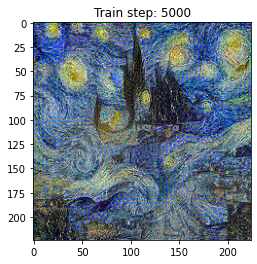

Total time: 200.7


In [22]:
import IPython.display as display
import time
import imageio

start = time.time()

image = tf.Variable(target_image)

epochs = 50
steps_per_epoch = 100
step = 0

for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
    if n % 5 == 0 or n == epochs - 1:
        imageio.imwrite('style_epoch_{0}.png'.format(n), image.read_value().numpy())
    display.clear_output(wait=True)
    plt.imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [23]:
def high_pass_x_y(image):
    x_var = image[:,1:,:] - image[:,:-1,:]
    y_var = image[1:,:,:] - image[:-1,:,:]
    return x_var, y_var

def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)

print('target   :', total_variation_loss(image.read_value()))
print('noise    :', total_variation_loss(tf.random.uniform(style_image.shape)))
print('original :', total_variation_loss(style_image))

target   : tf.Tensor(0.098744035, shape=(), dtype=float32)
noise    : tf.Tensor(0.3327871, shape=(), dtype=float32)
original : tf.Tensor(0.0338248563295889, shape=(), dtype=float64)


In [24]:
total_variation_weight = 1e9
style_weight = 1e-1

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = get_outputs(image)
        loss = style_weight * get_loss(outputs, style_outputs) #추가
        loss += total_variation_weight * total_variation_loss(image) #추가

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

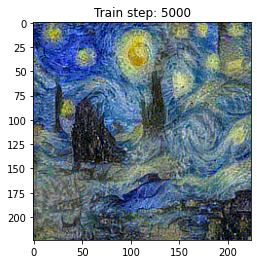

Total time: 204.8


In [25]:
start = time.time()

target_image = tf.random.uniform(style_image.shape)
image = tf.Variable(target_image)

epochs = 50
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
    if n % 5 == 0 or n == epochs - 1:
        imageio.imwrite('style_variation_epoch_{0}.png'.format(n), image.read_value().numpy())
    display.clear_output(wait=True)
    plt.imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [26]:
print('target   :', total_variation_loss(image.read_value()))
print('original :', total_variation_loss(style_image))

target   : tf.Tensor(0.027523, shape=(), dtype=float32)
original : tf.Tensor(0.0338248563295889, shape=(), dtype=float64)


8.3.2 컨볼루션 신경망을 사용한 신경 스타일 전이

770048/754420 [==============================] - 1s 2us/step


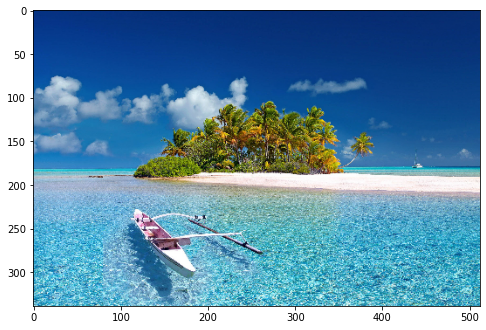

In [27]:
import matplotlib.pyplot as plt
import cv2

content_path = tf.keras.utils.get_file('content.jpg', 'http://bit.ly/2mAfUX1')

content_image = plt.imread(content_path)
max_dim = 512
long_dim = max(content_image.shape[:-1])
scale = max_dim / long_dim
new_height = int(content_image.shape[0] * scale)
new_width = int(content_image.shape[1] * scale)

content_image = cv2.resize(content_image, dsize=(new_width, new_height))
content_image = content_image / 255.0
plt.figure(figsize=(8,8))
plt.imshow(content_image)

In [28]:
content_batch = content_image.astype('float32')
content_batch = tf.expand_dims(content_batch, axis=0)

content_layers = ['block5_conv2']

vgg.trainable = False
outputs = [vgg.get_layer(name).output for name in content_layers]
model_content = tf.keras.Model([vgg.input], outputs)
content_output = model_content(preprocess_input(content_batch * 255.0))

In [29]:
def get_content_output(image):
    image_batch = tf.expand_dims(image, axis=0)
    output = model_content(preprocess_input(image_batch * 255.0))
    return output

def get_content_loss(image, content_output):
    return tf.reduce_sum(tf.reduce_mean(image-content_output)**2)

opt = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.99, epsilon=1e-1)

total_variation_weight = 1e9
style_weight = 1e-2
content_weight = 1e4

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = get_outputs(image)
        output2 = get_content_output(image)
        loss = style_weight * get_loss(outputs, style_outputs)
        loss += content_weight * get_content_loss(output2, content_output)
        loss += total_variation_weight * total_variation_loss(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

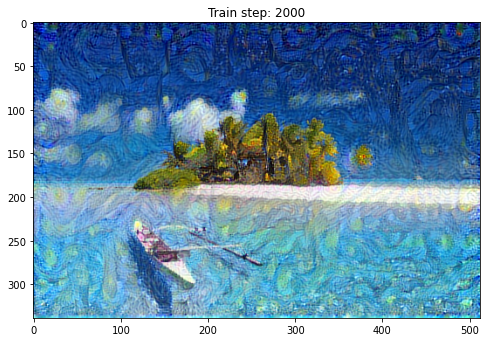

Total time: 563.0


In [30]:
start = time.time()

# target_image = tf.random.uniform(content_image.shape)
image = tf.Variable(content_image.astype('float32'))

epochs = 20
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    if n % 5 == 0 or n == epochs - 1:
        imageio.imwrite('style_{0}_content_{1}_transfer_epoch_{2}.png'.format(style_weight, content_weight, n), image.read_value().numpy())
    display.clear_output(wait=True)
    plt.figure(figsize=(8,8))
    plt.imshow(image.read_value())
    plt.title("Train step: {}".format(step))
    plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))